# Q-Learning For Decision

### 1. Setup & Environment Logic

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Config
ALPHA, GAMMA, EPSILON = 0.1, 0.9, 0.5

# GAMMA controls how much importance the agent gives to future rewards when making decisions.
# ALPHA controls the learning rate, determining how much the Q-value is updated based on the new experience.
# EPSILON controls the exploration rate, determining the probability of taking a random action.

ACTIONS = {
    0: "REJECT",
    1: "APPROVE_LOW", 
    2: "APPROVE_MEDIUM", 
    3: "APPROVE_HIGH"
}

In [2]:
BINS = {
    "pd": [0.10, 0.30, 0.50, 0.70], 
    "anom": [0.2, 0.4, 0.6], 
    "cs": [400, 500, 600, 700]
}

In [3]:
def get_state(r, pd_key='PD', anom_key='anomaly', cs_key='credit_score'):
    return (np.digitize(r[pd_key], BINS['pd']),
            np.digitize(r[anom_key], BINS['anom']),
            np.digitize(r[cs_key], BINS['cs']))

### Logic of Reward Function

#### 🔹 Case 1 — Action = REJECT (0)

| Condition | Meaning                                | Reward |
|----------|----------------------------------------|--------|
| PD > 0.3 | Rejected risky customer                | +10    |
| PD ≤ 0.3 | Rejected safe customer (missed profit) | -50    |

#### 🔹 Case 2 — Action = APPROVE (1,2,3)

| Action | Loan Tier      | Tier Value |
|--------|----------------|------------|
| 1      | APPROVE_LOW    | 100        |
| 2      | APPROVE_MEDIUM | 500        |
| 3      | APPROVE_HIGH   | 1000       |
---
> PD < 0.20 → positive value → profit  
---
> PD > 0.20 → negative value → loss  
---
> PD directly represents expected financial loss, which is the primary quantity a lending RL

In [4]:
def calculate_reward(action, pd_val):
    if action == 0: 
        return 10 if pd_val > 0.75 else -50 # Reject logic
    
    return [0, 100, 500, 1000][action] * (0.050 - pd_val) # Approval profit line

### 🔃 Reinforcement Learning Interaction Loop

The Reinforcement Learning agent operates using the following interaction cycle:

> #### &nbsp; State (sₜ) &nbsp; → &nbsp; Action (aₜ) &nbsp; → &nbsp;  Reward (rₜ) &nbsp; → &nbsp; Next State (sₜ₊₁) &nbsp; → &nbsp; Update Q(sₜ, aₜ) 

### 🎯 Intuition

> #### Good decisions -> increase long-term profitability.  
> #### Bad or no decisions -> reduce long-term profitability.

---

### ✅ What a Good Decision Produces

- #### Positive immediate reward (profit)  
- Improved next state (lower PD, higher credit score)  
- Higher future earning potential  

---

### ❌ What a Bad Decision Produces

- ##### Negative immediate reward (loss)  
- Degraded next state (higher PD, lower credit score)  
- Lower future earning potential  


In [5]:
def move_state(pd, anom, cs, action):
    # Higher anomaly makes negative effects worse and positive effects smaller
    risk_multiplier = 1.0 + anom 
    
    if action == 0: # REJECT
        cs -= random.uniform(0, 5) * risk_multiplier  # Reducr Score 
        pd += random.uniform(-0.01, 0.02) * risk_multiplier # Increase PD

    else: # APPROVE (1, 2, 3)

        # Approval might improve state, but high anomaly dampens the benefit
        improvement_factor = max(0, 1.0 - anom) 
        cs += random.uniform(5, 10 * action) * improvement_factor
        pd -= random.uniform(0.01, 0.03 * action) * improvement_factor
        
        
        # Anomaly itself might evolve - approving high anomaly might lead to higher anomaly
        if anom > 0.05:
            anom += random.uniform(0, 0.05 * action)
        else:
            anom -= random.uniform(0, 0.02)

    pd = np.clip(pd, 0, 1)   
    anom = np.clip(anom, 0, 1)
    cs = np.clip(cs, 300, 900)

    return pd, anom, cs

### 2. End-to-End Training

In [6]:
print("🔃 Initializing environment...")
pd_df = pd.read_csv("../../../3. Data/2. PD_Data/features_with_pd_predictions.csv")[["avgMonthlyIncome","bounceCount","PD"]]
hyb_df = pd.read_csv("../../../3. Data/5*. Hybrid_Data/*Hybrid_Credit_Scores.csv")[["avgMonthlyIncome","bounceCount","HybridCreditScore"]]
anom_df = pd.read_csv("../../../3. Data/3. Anomaly_Data/features_with_anomaly.csv")[["avgMonthlyIncome","bounceCount","anomaly_score"]]

# Merge all three sources
df = pd.merge(pd_df, hyb_df, on=["avgMonthlyIncome","bounceCount"])
df = pd.merge(df, anom_df, on=["avgMonthlyIncome","bounceCount"])

# Map real anomaly scores
df['anomaly'] = df['anomaly_score']

# Initialize Q-table
Q = defaultdict(lambda: np.zeros(4))
history = []
eps = EPSILON # EPSILON => Explore Vs Exploit = 0.5

🔃 Initializing environment...


### 🧮 Q-Learning Update Rule (Bellman Equation)

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \big[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \big]
$$

### NewQ-value = OldQ-value + Learning Rate × (  
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    Reward received  + Discount Factor × Best future Q-value  - OldQ-value  
### &nbsp;&nbsp;&nbsp;)

> ### &nbsp; &nbsp; Q[state][action] = expected long-term reward

### 🧠 Q-Learning Training Flow

#### 1. Initialize Q-table  
#### 2. For each episode:
   - Sample customer states  
   - Choose action (ε-greedy)  
   - Compute reward  
   - Simulate next state  
   - Update Q-table (Bellman)  
#### 3. Decay ε  
#### 4. Extract final policy  


In [7]:
print(f"🚀 Training on {len(df)} records...")
episodes = 200

for ep in range(episodes):
    # For each episode
    total_r = 0

    for _, row in df.sample(frac=0.1).iterrows(): # Randomly sample 10% of data access by row
        
        # Step - a
        s = get_state(row, cs_key='HybridCreditScore')  # Get current state
        
        # Step - b
        # a => Action taken according to eps(Epsilon-Greedy)
        if random.random()< eps: # Explore
            a=random.randint(0,3) #Try something New
        else: # Exploit
            a=np.argmax(Q[s]) #Choose previous best action

        # Step - c
        # Calculate Reward
        r = calculate_reward(a, row['PD'])
        
        # Step - d
        # Simulate Next State
        n_pd, n_an, n_cs = move_state(row['PD'], row['anomaly'], row['HybridCreditScore'], a)
        ns = get_state({'PD': n_pd, 'anomaly': n_an, 'credit_score': n_cs})
        
        # Step - e
        # Update Rule
        Q[s][a] += ALPHA * (r + GAMMA * np.max(Q[ns]) - Q[s][a])
        total_r += r
    
    #Store history for analysis
    history.append(total_r / (len(df)*0.1))

    #Decay epsilon Because when loop increase epsilon decrease
    #When loop increase experinced data increase so Exploitation increase
    eps = max(0.05, eps * 0.995)
    
    if (ep+1) % 50 == 0: print(f"Episode {ep+1} | Avg Reward: {history[-1]:.2f}")

print("✅ Training Complete")

🚀 Training on 30042 records...
Episode 50 | Avg Reward: -49.59
Episode 100 | Avg Reward: -39.84
Episode 150 | Avg Reward: -26.76
Episode 200 | Avg Reward: -23.41
✅ Training Complete


### 📊 3. Results & Policy Test
Visualize the learning curve and verify choices for common customer types.

### Q[state({'PD', 'anomaly', 'credit_score'})] => Choice Best Action for input state

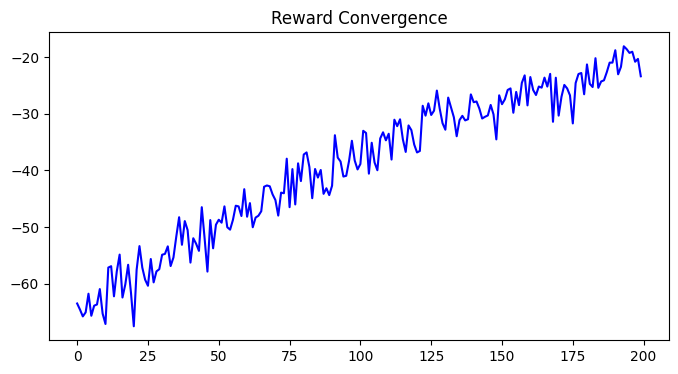


--- Policy Verification ---
PD: 0.05, CS: 750, Anom: 0.05 -> Decision: APPROVE_HIGH
PD: 0.04, CS: 559.2, Anom: 0.04 -> Decision: APPROVE_MEDIUM
PD: 0.25, CS: 550, Anom: 0.15 -> Decision: APPROVE_LOW


In [8]:
plt.figure(figsize=(8,4))
plt.plot(history, color='blue')
plt.title("Reward Convergence")
plt.show()

def check(pd, cs, anom=0.1):
    res = ACTIONS[np.argmax(Q[get_state({'PD':pd, 'anomaly':anom, 'credit_score':cs})])]
    print(f"PD: {pd:.2f}, CS: {cs}, Anom: {anom:.2f} -> Decision: {res}")

print("\n--- Policy Verification ---")
check(0.05, 750, 0.05) # Elite
check(0.0384, 559.2, 0.0416) # Risky
check(0.25, 550, 0.15) # Borderline

### 💾 4. Save Model & Artifacts

In [9]:
import joblib

# 1. Save Q-Table (Convert defaultdict to regular dict for clean serialization)
joblib.dump(dict(Q), '../artifacts/q_learning_model.joblib')

# 2. Save State Bins
joblib.dump(BINS, '../artifacts/q_learning_bins.joblib')

# 3. Save Feature Names for state representation
rl_features = ["PD", "anomaly", "HybridCreditScore"]
joblib.dump(rl_features, '../artifacts/q_learning_features.joblib')

print("✅ RL Model and Artifacts saved successfully!")

✅ RL Model and Artifacts saved successfully!
